<a href="https://colab.research.google.com/github/lwvc/FallDown/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 資料處理

In [ ]:
import pandas as pd

# 讀入資料
df = df_interpolated

# 加入 seq 欄位（如果有）
cols_to_keep = [col for col in df.columns if col.endswith('_x') or col.endswith('_y')]
cols_to_keep = ['video', 'frame', 'seq'] + cols_to_keep + ['label']  # 加入 seq

# 建立所有抽樣後的序列
sequences = []

for video, group in df.groupby('video'):
    group = group.sort_values('frame').reset_index(drop=True)
    total_frames = len(group)

    if total_frames < 9:
        continue

    step = total_frames // 9  # 動態間隔 ex: 18→2, 27→3, 36→4

    for offset in range(step):
        sampled = group.iloc[offset::step].head(9)
        if len(sampled) == 9:
            sampled = sampled[cols_to_keep].copy()
            sampled['seq_id'] = f"{video}_start{offset+1}"
            sampled['seq_frame'] = range(1, 10)
            sequences.append(sampled)

# 合併所有序列
result_df = pd.concat(sequences, ignore_index=True)

# 輸出檔案
result_df.to_csv("/content/drive/MyDrive/訓練/data/sequence_9frames_with_seq.csv", index=False)
print(f"✅ 儲存成功，共有 {result_df['seq_id'].nunique()} 組序列，保留 seq 欄位")


✅ 儲存成功，共有 6049 組序列，保留 seq 欄位


# 訓練 LSTM 模型

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

## 輸入訓練資料

In [ ]:
def load_data(file_path):
  df = pd.read_csv(file_path)
  print(f"數據形狀: {df.shape}")

  # 檢查是否有缺失值
  missing_count = df.isnull().sum().sum()
  if missing_count > 0:
    print(f"⚠️發現缺失值，共{missing_count}個，已補0")
    df = df.fillna(0).infer_objects(copy=False)
  else:
    print("✅ 無缺失值")

  # 跌倒(label 5) = 1，非跌倒 = 0
  df['fall_label'] = (df['label'] == 5).astype(int)
  print(f"跌倒標籤分布: {df['fall_label'].value_counts().to_dict()}")
  return df
df = load_data("/content/drive/MyDrive/訓練/data/Data.csv")

數據形狀: (54441, 30)
⚠️發現缺失值，共1080個，已補0
跌倒標籤分布: {0: 43272, 1: 11169}


In [ ]:
print(df[df['video'] == 'F02']['right_elbow_x'].head())

36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
Name: right_elbow_x, dtype: float64


## 正規化

In [ ]:
def normalize_keypoints(df):
  # 計算兩個髖關節的中心點
  hip_center_x = (df['left_hip_x'] + df['right_hip_x']) / 2
  hip_center_y = (df['left_hip_y'] + df['right_hip_y']) / 2

  # 所有關鍵點座標欄位
  keypoint_cols = [col for col in df.columns if col.endswith('_x') or col.endswith('_y')]

  # 以髖關節中心為原點進行正規化
  for col in keypoint_cols:
    if col.endswith('_x'):
        df[col] = df[col] - hip_center_x
    elif col.endswith('_y'):
        df[col] = df[col] - hip_center_y

  print(f"已完成正規化")
  return df
nor_df = normalize_keypoints(df)

已完成正規化


## 創建序列數據

In [ ]:
def create_sequences(df):
  sequences = []
  labels = []

  # 提取特徵欄位
  feature_cols = [col for col in df.columns if col.endswith('_x') or col.endswith('_y')]

  # 按video分組處理
  for video in df['video'].unique():
    video_data = df[df['video'] == video]
    # 找完整的1-9序列
    i = 0
    while i <= len(video_data) - 9:
      seq_data = video_data.iloc[i:i+9]
      if list(seq_data['seq']) == list(range(1, 10)):
        sequences.append(seq_data[feature_cols].values)
        labels.append(seq_data['fall_label'].iloc[-1])
        i += 9
      else:
        i += 1

  sequences = np.array(sequences)
  labels = np.array(labels)

  return sequences, labels

X, y = create_sequences(nor_df)

In [ ]:
has_nan = np.isnan(X).any()

if has_nan:
    print("⚠️X中包含缺失值 (NaN)")
    nan_count = np.isnan(X).sum()
    print(f"共有 {nan_count} 個 NaN 值")
else:
    print("✅X中不含缺失值")

✅X中不含缺失值


In [ ]:
print(X.shape)
print(y.shape)
# print(X[0])
print(f"跌倒: {np.sum(y == 1)}")
print(f"非跌倒: {np.sum(y == 0)}")

(6049, 9, 26)
(6049,)
跌倒: 1241
非跌倒: 4808


## 分割數據集

In [ ]:
# 訓練和測試
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 訓練和驗證
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"訓練集: {X_train_split.shape}，驗證集: {X_val.shape}, 測試集: {X_test.shape}")

訓練集: (3871, 9, 26)，驗證集: (968, 9, 26), 測試集: (1210, 9, 26)


In [ ]:
has_nan = np.isnan(X_test).any()

if has_nan:
    print("⚠️X中包含缺失值 (NaN)")
    nan_count = np.isnan(X).sum()
    print(f"共有 {nan_count} 個 NaN 值")
else:
    print("✅X中不含缺失值")

✅X中不含缺失值


## 模型參數、最佳化器、損失函數和評估指標

In [ ]:
lstm_units = 512
dense_units = 32
output_units = 1
batch_size = 512
epochs = 50

optimizer = Adam(learning_rate=0.001) #最佳化演算法進行權重更新
loss = 'binary_crossentropy'
metrics = ['accuracy']

## 創建模型

In [ ]:
def build_model(input_shape):

  model = Sequential([
    tf.keras.Input(shape=input_shape),
    LSTM(lstm_units, activation='tanh', dropout=0.2),
    Dense(dense_units, activation='relu'),
    Dropout(0.3),
    Dense(output_units, activation='sigmoid')
  ])

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  return model

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

## 模型結構和參數量

In [ ]:
print(f"模型參數量: {model.count_params()}")
model.summary()

模型參數量: 1120321


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 512)            │     1,103,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,120,321 (4.27 MB)

 Trainable params: 1,120,321 (4.27 MB)

 Non-trainable params: 0 (0.00 B)

## 權重處理

In [ ]:
def get_class_weights(y_train):
  classes = np.unique(y_train)
  weights = compute_class_weight('balanced', classes=classes, y=y_train)
  class_weights = dict(zip(classes, weights)) # 自動平衡比重
  print(f"類別權重: {class_weights}")
  return class_weights
class_weights = get_class_weights(y_train)

類別權重: {np.int64(0): np.float64(0.6290951638065523), np.int64(1): np.float64(2.4365558912386707)}


## 訓練模型

In [ ]:
# 回調函數
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), #如果連續10輪驗證損失沒有進步就停止訓練，回復最好的權重
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6) #如果連續5輪驗證損失沒改善將學習率減半
]

# 訓練
history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=epochs,batch_size=batch_size, class_weight=class_weights, callbacks=callbacks, verbose=1)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 677ms/step - accuracy: 0.6583 - loss: 0.6663 - val_accuracy: 0.8306 - val_loss: 0.5057 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 727ms/step - accuracy: 0.7169 - loss: 0.5346 - val_accuracy: 0.8368 - val_loss: 0.3791 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 635ms/step - accuracy: 0.8330 - loss: 0.3583 - val_accuracy: 0.9029 - val_loss: 0.2521 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 614ms/step - accuracy: 0.8495 - loss: 0.4355 - val_accuracy: 0.9236 - val_loss: 0.2870 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 827ms/step - accuracy: 0.8984 - loss: 0.3583 - val_accuracy: 0.8781 - val_loss: 0.3416 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 637ms/step - accuracy: 0.8764 - loss: 0.2856 - val_accuracy: 0.9122 - val_loss: 0.2557 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 893ms/step - accuracy: 0.8997 - loss: 0.2374

## 評估模型

In [ ]:
def evaluate_model(model, X_test, y_test):
  # 預測
  y_pred_prob = model.predict(X_test, verbose=0)
  y_pred = (y_pred_prob > 0.5).astype(int).flatten()

  # 基本指標
  test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
  auc_score = roc_auc_score(y_test, y_pred_prob)

  print(f"測試準確率: {test_acc:.4f}")
  print(f"測試損失: {test_loss:.4f}")
  print(f"AUC分數: {auc_score:.4f}")

  # 分類報告
  print("\n分類報告:")
  print(classification_report(y_test, y_pred, target_names=['非跌倒', '跌倒']))

  return y_pred, y_pred_prob

y_pred, y_pred_prob = evaluate_model(model, X_test, y_test)

測試準確率: 0.9752
測試損失: 0.0664
AUC分數: 0.9942

分類報告:
              precision    recall  f1-score   support

         非跌倒       0.98      0.99      0.98       962
          跌倒       0.95      0.93      0.94       248

    accuracy                           0.98      1210
   macro avg       0.96      0.96      0.96      1210
weighted avg       0.98      0.98      0.98      1210



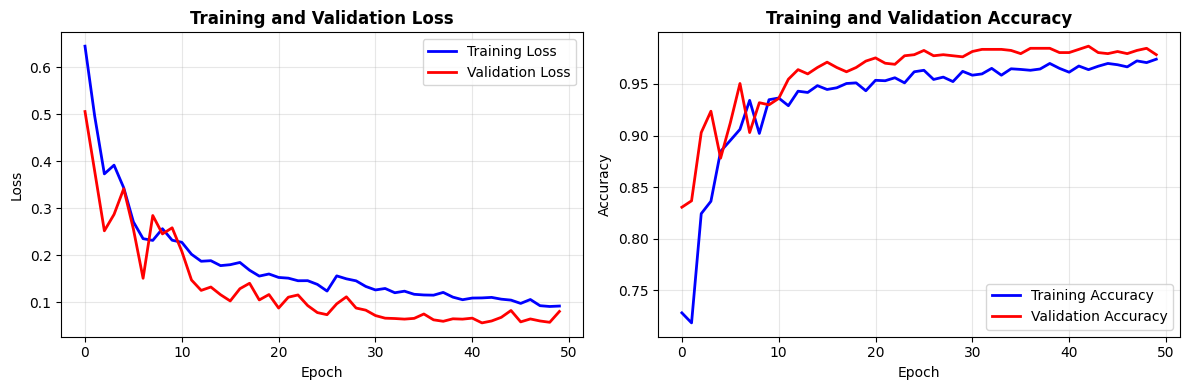

In [ ]:
def plot_training_curves(history):
  """繪製訓練曲線"""
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

  # 損失曲線
  ax1.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
  ax1.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
  ax1.set_title('Training and Validation Loss', fontweight='bold')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()
  ax1.grid(True, alpha=0.3)

  # 準確率曲線
  ax2.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
  ax2.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
  ax2.set_title('Training and Validation Accuracy', fontweight='bold')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  ax2.grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()
plot_training_curves(history)

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 38750 (\N{CJK UNIFIED IDEOGRAPH-975E}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 36300 (\N{CJK UNIFIED IDEOGRAPH-8DCC}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20498 (\N{CJK UNIFIED IDEOGRAPH-5012}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38750 (\N{CJK UNIFIED IDEOGRAPH-975E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36300 (\N{CJK UNIFIED IDEOGRAPH-8DCC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:15

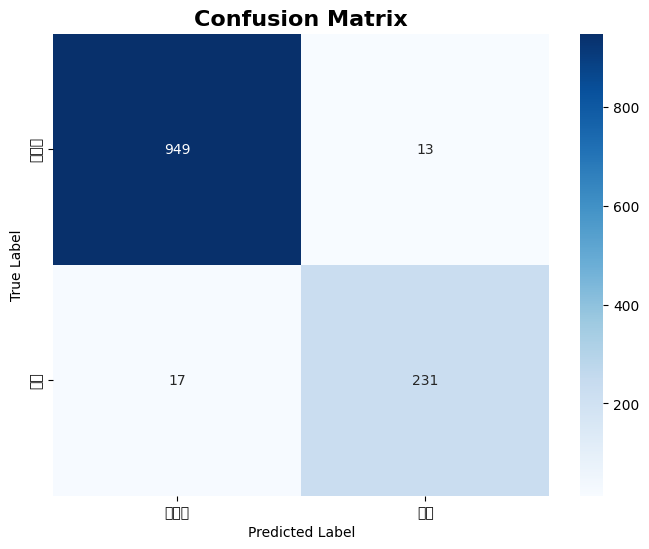


混淆矩陣結果:
真負例(TN): 949
假正例(FP): 13
假負例(FN): 17
真正例(TP): 231


In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  """繪製混淆矩陣"""
  cm = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['非跌倒', '跌倒'],
              yticklabels=['非跌倒', '跌倒'])
  plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

  # 輸出數值
  tn, fp, fn, tp = cm.ravel()
  print(f"\n混淆矩陣結果:")
  print(f"真負例(TN): {tn:,}")
  print(f"假正例(FP): {fp:,}")
  print(f"假負例(FN): {fn:,}")
  print(f"真正例(TP): {tp:,}")
plot_confusion_matrix(y_test, y_pred)

In [ ]:
def test_model_speed(model, X_test_sample):
  """測試模型推理速度"""
  import time

  # 單次推理測試
  single_sample = X_test_sample[:1]  # 取一個樣本

  # 預熱
  for _ in range(10):
      _ = model.predict(single_sample, verbose=0)

  # 測試單次推理時間
  times = []
  for _ in range(100):
      start = time.time()
      _ = model.predict(single_sample, verbose=0)
      times.append(time.time() - start)

  avg_time = np.mean(times) * 1000  # 轉換為毫秒
  print(f"\n=== 推理速度測試 ===")
  print(f"單次推理平均時間: {avg_time:.2f} ms")
  print(f"每秒可處理: {1000/avg_time:.1f} 個樣本")

test_model_speed(model, X_test)


=== 推理速度測試 ===
單次推理平均時間: 108.84 ms
每秒可處理: 9.2 個樣本


In [ ]:
model.save("/content/drive/MyDrive/訓練/fall_detection.keras")
print(f"模型已儲存: fall_detection.keras")

模型已儲存: fall_detection.keras
